In [41]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from elo_mmr_py import Contest, rate
from IPython.display import display, HTML
from collections import defaultdict



# Data preprocessing and cleaning

In [110]:
athlete_info = pd.read_csv('athlete_information.csv')
athlete_results = pd.read_csv('athlete_results.csv')

### Set column types

In [111]:
for col in ['firstname', 'lastname', 'gender', 'country', 'paraclimbing_sport_class']:
    athlete_info[col] = athlete_info[col].astype(str)

athlete_info['birthday'] = pd.to_datetime(athlete_info['birthday'].str[:10], format='%Y-%m-%d')


for col in ['discipline', 'event_location']:
    athlete_results[col] = athlete_results[col].astype(str)

athlete_results['date'] = pd.to_datetime(athlete_results['date'].str[:10], format='%Y-%m-%d')


### For this analysis we will only look at non paraclimbing athletes.

In [112]:
able_bodied = athlete_info[athlete_info['paraclimbing_sport_class'] == 'nan'].copy()
del athlete_info
able_bodied[['height', 'arm_span', 'age']].describe()

,height,arm_span,age
count,816.000000,299.000000,8481.000000
mean,170.851716,170.889632,27.619149
std,56.187952,102.294406,11.716531
min,1.000000,-1.000000,4.000000
25%,164.000000,166.000000,19.000000
50%,170.000000,177.000000,24.000000
75%,176.000000,183.000000,33.000000
max,1710.000000,1780.000000,124.000000


### Remove outliers

In [113]:
# drop athletes with height or arm span greater than 1000
able_bodied = able_bodied[(able_bodied['height'].isnull()) | (able_bodied['height'] < 1000)]
able_bodied = able_bodied[(able_bodied['arm_span'].isnull()) | (able_bodied['arm_span'] < 1000)]

# drop athletes with height or arm span less than 100
able_bodied = able_bodied[(able_bodied['height'].isnull()) | (able_bodied['height'] > 100)]
able_bodied = able_bodied[(able_bodied['arm_span'].isnull()) | (able_bodied['arm_span'] > 100)]

# Keep only able-bodied athlete results
athlete_results = athlete_results[athlete_results['athlete_id'].isin(able_bodied['athlete_id'])]
athlete_results = athlete_results[athlete_results['rank'] < 999]


### We are only interested in the boulder discipline and lead disipline.

In [114]:
athlete_results = pd.merge(
    athlete_results,               
    able_bodied[['athlete_id', 'gender', 'age', 'birthday', 'country']],  
    on='athlete_id',                  
    how='left'                        
)

athlete_results = athlete_results[(athlete_results['discipline'] == 'boulder') | (athlete_results['discipline'] == 'lead')]

athlete_results.describe(include='all')    

,athlete_id,rank,discipline,season,date,event_id,event_location,d_cat,gender,age,birthday,country
count,105333.000000,105333.000000,105333,105333.000000,105333,105333.000000,105333,105333.000000,105333,68804.000000,68804,105333
unique,NaN,NaN,2,NaN,NaN,NaN,497,NaN,2,NaN,NaN,93
top,NaN,NaN,lead,NaN,NaN,NaN,Imst,NaN,male,NaN,NaN,FRA
freq,NaN,NaN,64716,NaN,NaN,NaN,3719,NaN,59937,NaN,NaN,10537
mean,4913.224108,25.742588,NaN,2011.997142,2012-07-31 09:56:49.085471744,781.168542,NaN,126.158326,NaN,27.496701,1996-10-05 06:30:52.217894272,NaN
min,1.000000,1.000000,NaN,1991.000000,1991-04-26 00:00:00,65.000000,NaN,1.000000,NaN,13.000000,1951-08-16 00:00:00,NaN
25%,1449.000000,10.000000,NaN,2006.000000,2006-05-28 00:00:00,432.000000,NaN,5.000000,NaN,21.000000,1992-02-06 00:00:00,NaN
50%,4169.000000,21.000000,NaN,2014.000000,2014-05-11 00:00:00,851.000000,NaN,27.000000,NaN,26.000000,1998-06-08 00:00:00,NaN
75%,6694.000000,36.000000,NaN,2019.000000,2019-04-28 00:00:00,1117.000000,NaN,241.000000,NaN,32.000000,2002-11-26 00:00:00,NaN
max,16408.000000,152.000000,NaN,2024.000000,2024-10-06 00:00:00,1396.000000,NaN,615.000000,NaN,73.000000,2010-12-30 00:00:00,NaN


### Drop athlete events that are duplicated (only 154 of these)

An athlete should not be able to compete in the same event and discipline more than once. We will assume any such data is inaccurate and remove it.

In [115]:
duplicate_athlete_events = athlete_results.duplicated(subset=['event_id', 'athlete_id', 'discipline'], keep=False)
print(f"There are {sum(duplicate_athlete_events)} duplicate athlete events")

athlete_results = athlete_results[~duplicate_athlete_events]

There are 154 duplicate athlete events


## Validating Competitions

In our work a competition is uniquely identified by its event_id and d_cat. Lets ensure that discipline and gender are constant for each competition. We should also confirm that rankings in competitions behave as we expect them to - that is for each competition the rankings should be a subset of positive integers that has no gaps (with the exception of ties, where the rank of each tied contestant is the largest rank of the contestants if there was no tie)

### Check discipline and gender consistency

In [116]:
def check_consistency(df):
    # Group by event_id and d_cat
    grouped = df.groupby(['event_id', 'd_cat'])

    inconsistent_groups = []

    for (event_id, d_cat), group in grouped:
        
        # Check if all values in 'gender' are the same
        if group['gender'].nunique() > 1:
            inconsistent_groups.append({
                'event_id': event_id,
                'd_cat': d_cat,
                'issue': 'Inconsistent gender',
                'values': group['gender'].unique()
            })

        # Check if all values in 'discipline' are the same
        if group['discipline'].nunique() > 1:
            inconsistent_groups.append({
                'event_id': event_id,
                'd_cat': d_cat,
                'issue': 'Inconsistent discipline',
                'values': group['discipline'].unique()
            })


    inconsistent_df = pd.DataFrame(inconsistent_groups)

    if not inconsistent_df.empty:
        print("Inconsistent groups found:")
        print(inconsistent_df)
    else:
        print("No inconsistencies found. Discipline and gender are constant for each competition.")

    return inconsistent_df

inconsistent_groups = check_consistency(athlete_results)


Inconsistent groups found:
   event_id  d_cat                issue          values
0       433      5  Inconsistent gender  [female, male]
1       752    213  Inconsistent gender  [female, male]


There are two competitions that have female and male participants. There are no competitions that have multiple disciplines (good!). We can investigate a little further in these three competitions.

In [117]:
import pandas as pd

def check_consistency(df):
    # Group by event_id and d_cat
    grouped = df.groupby(['event_id', 'd_cat'])

    inconsistent_groups = []

    for (event_id, d_cat), group in grouped:
        
        # Check for gender inconsistencies
        if group['gender'].nunique() > 1:
            # Get the value counts for 'gender'
            gender_counts = group['gender'].value_counts()

            # Find the smallest value group for 'gender'
            smallest_gender_value = gender_counts.idxmin()
            smallest_gender_athletes = group[group['gender'] == smallest_gender_value]['athlete_id'].tolist()

            inconsistent_groups.append({
                'event_id': event_id,
                'd_cat': d_cat,
                'issue': 'Inconsistent gender',
                'value_counts': gender_counts.to_dict(),
                'smallest_value_group': smallest_gender_value,
                'athlete_ids': smallest_gender_athletes
            })

    inconsistent_df = pd.DataFrame(inconsistent_groups)

    if not inconsistent_df.empty:
        print("Inconsistent groups found:")
        print(inconsistent_df)
    else:
        print("No inconsistencies found. Discipline and gender are constant for each competition.")

    return inconsistent_df

# Run the consistency check
inconsistent_groups = check_consistency(athlete_results)


Inconsistent groups found:
   event_id  d_cat                issue               value_counts  \
0       433      5  Inconsistent gender  {'female': 48, 'male': 1}   
1       752    213  Inconsistent gender  {'female': 17, 'male': 1}   

  smallest_value_group athlete_ids  
0                 male      [5082]  
1                 male     [10798]  


In [50]:
%%capture
def display_scrollable_dataframe(df, max_height=200):
    display(HTML(f"""
    <div style="max-height: {max_height}px; overflow-y: scroll;">
        {df.to_html()}
    </div>
    """))

In [118]:
display_scrollable_dataframe(athlete_results.query('event_id == 752 & d_cat == 213').sort_values(by='rank'))

,athlete_id,rank,discipline,season,date,event_id,event_location,d_cat,gender,age,birthday,country
39910,2053,1,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,28.0,1996-05-21,KOR
39846,2050,2,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,28.0,1995-10-29,KOR
61025,3363,3,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,28.0,1996-01-10,KAZ
111876,10657,4,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,NaN,NaT,CHN
88594,2623,5,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,29.0,1995-08-03,IND
63860,3632,6,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,27.0,1996-11-29,SGP
63342,3631,7,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,28.0,1996-02-24,SGP
112450,10797,8,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,NaN,NaT,SGP
111849,10648,9,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,NaN,NaT,IRI
112311,10796,10,lead,2012,2012-07-13,752,Asian_Youth_Chp_12,213,female,NaN,NaT,IRI


In [119]:
display_scrollable_dataframe(athlete_results.query('event_id == 433 & d_cat == 5').sort_values(by='rank'))

,athlete_id,rank,discipline,season,date,event_id,event_location,d_cat,gender,age,birthday,country
26230,1207,1,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,38.0,1986-01-27,AUT
8640,438,2,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,39.0,1985-03-06,FRA
24632,1119,3,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,39.0,1984-11-29,SLO
29153,1202,4,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,42.0,1982-08-10,AUT
10709,445,5,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,34.0,1990-08-18,FRA
22419,1121,6,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,38.0,1985-12-30,SLO
9888,430,7,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,42.0,1982-07-22,FRA
6195,306,8,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,50.0,1974-08-05,BEL
70797,4455,9,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,NaN,NaT,FRA
87446,5282,10,lead,2006,2006-07-13,433,Chamonix (L+S),5,female,NaN,NaT,USA


The above tells us that that two male athletes have participated in a female competition only once. Their rankings in the competitions do not show any signs of invalid data. I will not make any assumptions and keep these athlete results in our data; perhaps some special circumstances allowed them to do them to compete.

### Check ranking consistency

In [120]:
def check_rank_consistency(df):
    grouped = df.groupby(['event_id', 'd_cat'])

    inconsistencies = []

    for (event_id, d_cat), group in grouped:
        # Sort the group by rank to ensure we're working with an ordered list of rankings
        group = group.sort_values(by='rank').reset_index(drop=True)

        expected_ranks = []
        current_rank = 1
        for i in range(len(group)):
            if i > 0 and group.loc[i, 'rank'] == group.loc[i - 1, 'rank']:
                # If the current rank is tied with the previous, continue using the same rank
                expected_ranks.append(expected_ranks[-1])
            else:
                # If no tie, assign the current expected rank
                expected_ranks.append(current_rank)
            current_rank += 1

        actual_ranks = group['rank'].tolist()

        if actual_ranks != expected_ranks:
            inconsistencies.append({
                'event_id': event_id,
                'd_cat': d_cat,
                'actual_ranks': actual_ranks,
                'expected_ranks': expected_ranks
            })

    inconsistent_df = pd.DataFrame(inconsistencies)

    if not inconsistent_df.empty:
        print(f"{len(inconsistent_df)} rank inconsistencies found:")
        display_scrollable_dataframe(inconsistent_df, max_height=400)
    else:
        print("All rankings are consistent with the expected behavior.")

    return inconsistent_df

rank_inconsistencies = check_rank_consistency(athlete_results)


407 rank inconsistencies found:


,event_id,d_cat,actual_ranks,expected_ranks
0,114,1,"[1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 18, 18, 18, 18, 22, 22, 24, 25, 26, 27, 27, 27, 27, 31, 32, 33, 33, 35, 35, 35, 35, 35, 35, 41, 42, 43, 44, 44, 46, 46, 49, 50, 50, 50, 53, 54, 55, 55, 57]","[1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 18, 18, 18, 18, 22, 22, 24, 25, 26, 27, 27, 27, 27, 31, 32, 33, 33, 35, 35, 35, 35, 35, 35, 41, 42, 43, 44, 44, 46, 46, 48, 49, 49, 49, 52, 53, 54, 54, 56]"
1,148,9,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 22, 23, 23, 23, 26, 26, 28, 29, 30, 31, 31, 31, 31, 35, 36, 36, 38, 39, 40, 41]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 19, 21, 22, 22, 22, 25, 25, 27, 28, 29, 30, 30, 30, 30, 34, 35, 35, 37, 38, 39, 40]"
2,148,13,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25, 27, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 26, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]"
3,160,237,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 20]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 19]"
4,160,241,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 12, 14, 15, 16, 17, 18, 19, 20]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 13, 14, 15, 16, 17, 18, 19]"
5,216,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 29]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28]"
6,248,5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 13, 14, 15, 15, 15, 18, 19, 20, 21, 21, 23, 23, 23, 26, 27, 27, 29, 29, 31, 31, 31, 31, 35, 36, 37, 37, 37, 40, 42, 42]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 13, 14, 15, 15, 15, 18, 19, 20, 21, 21, 23, 23, 23, 26, 27, 27, 29, 29, 31, 31, 31, 31, 35, 36, 37, 37, 37, 40, 41, 41]"
7,263,457,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]"
8,275,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 17, 18, 19, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 31, 31, 31, 35, 36, 37, 37, 39, 39, 41, 41, 41, 41, 45, 46, 47, 47, 49, 49, 50, 50, 53, 54]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 17, 18, 19, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 31, 31, 31, 35, 36, 37, 37, 39, 39, 41, 41, 41, 41, 45, 46, 47, 47, 49, 49, 51, 51, 53, 54]"
9,283,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 11, 11, 11, 17, 17, 19, 19, 21, 22, 23, 23, 25, 26, 27, 29, 29, 31, 31, 31, 31, 31, 31, 31, 38, 39, 39, 41, 42, 42, 44, 45, 45, 45, 48, 48, 50, 51, 51, 53, 53, 53, 56, 56, 58, 58, 60, 61, 61, 63, 63, 63, 63, 67, 68, 69, 69]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 11, 11, 11, 17, 17, 19, 19, 21, 22, 23, 23, 25, 26, 27, 28, 28, 30, 30, 30, 30, 30, 30, 30, 37, 38, 38, 40, 41, 41, 43, 44, 44, 44, 47, 47, 49, 50, 50, 52, 52, 52, 55, 55, 57, 57, 59, 60, 60, 62, 62, 62, 62, 66, 67, 68, 68]"


There are 407 competitions with rankings that differ from the expected convention. I suspect this may be due to missing data in our athlete_results dataset. However this issue will not be a problem for our elo-mmr calculations, and so I will not modify these rankings.

We can turn our attention to the number of participants. It is not much of a competition if there is only one person competing, and so we will remove any competitions with only one participant.

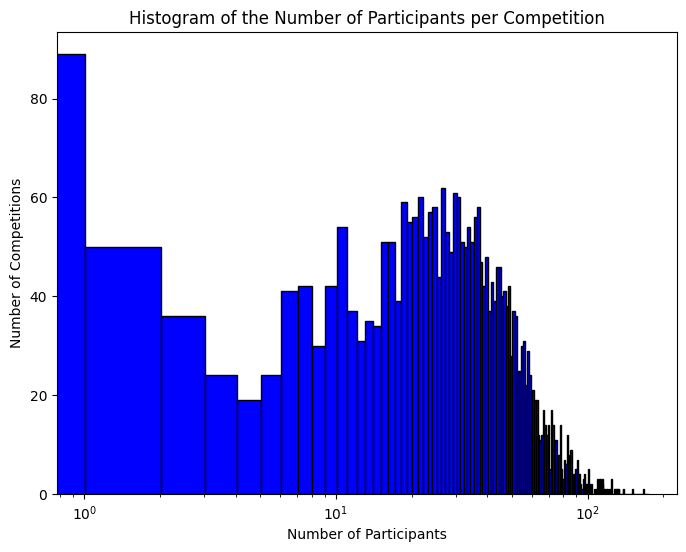

In [122]:
participant_counts = athlete_results.groupby(['event_id', 'd_cat']).size().reset_index(name='participant_count')

valid_competitions = participant_counts[participant_counts['participant_count'] > 1]

bins = np.linspace(0, 175, 175)
plt.figure(figsize=(8, 6))
plt.hist(participant_counts['participant_count'], bins=bins, color='blue', edgecolor='black')

plt.xlabel('Number of Participants')
plt.ylabel('Number of Competitions')
plt.title('Histogram of the Number of Participants per Competition')

plt.xscale('log')

plt.show()



In [123]:
# Remove competitions with only one participant
athlete_results = pd.merge(
    athlete_results, 
    valid_competitions[['event_id', 'd_cat']], 
    on=['event_id', 'd_cat'], 
    how='inner'
)

In [125]:
print(f"We are left with {len(athlete_results.groupby(['event_id', 'd_cat']).size())} competitions.")

We are left with 2883 competitions.


# Calculating Elo-MMR over time

**What is Elo-MMR and why did I choose it?**

Elo-MMR is a Baysean rating system for contests with many participants introduced in a [paper](https://github.com/EbTech/Elo-MMR/blob/master/paper/EloMMR.pdf) by Aram Ebtekar and Paul Liu in 2021. They proved that Elo-MMR has the nice property of being *incentive-compatible*: this means that a player seeking to maximize their rating will never want to underperform. From the readme on their [github](https://github.com/EbTech/Elo-MMR/blob/master/README.md) they claim:

> Rating systems estimate the skills of players who participate in a common activity. The Elo-MMR algorithm was designed for activities in which moderate to large numbers of players are ranked at competitive events, and results cannot be standardized across different events for any of the following reasons:
>
> - Each event features novel challenges, such as in obstacle course races, rock climbing, and academic olympiads.
>
> - The contestants are evaluated relative to others at the same event, perhaps by a panel of judges with some degree of subjectivity, as in competitive ballroom, figure skating, and gymnastics.
>
> - The contestants interact heavily with others at the same event, as in most board games.

Indeed, rock climbing is a sport where each competition features novel challenges due to the seemingly endless repertoire of movements available to routesetters. Combined with the variable number of participants, this makes Elo-MMR a robust choice for a rating system.

now that we have cleaned and validated our data, it's time to calculate elo-mmr ratings of our athletes. We will use this [python binding](https://github.com/aropan/Elo-MMR-Py) for the elo-mmr package.

In [86]:


# Step 1: Function to reformat ranks for Elo-MMR
def reformat_ranks(group):
    # Sort by rank within each competition (event_id, d_cat)
    group = group.sort_values(by='rank').reset_index(drop=True)
    
    # Reformat ranks to be 0-based, and handle ties
    reformatted_ranks = []
    current_rank = 0
    
    i = 0
    while i < len(group):
        tied_ranks = [current_rank]  # Start with the current rank
        j = i + 1
        while j < len(group) and group.loc[i, 'rank'] == group.loc[j, 'rank']:
            tied_ranks.append(current_rank)
            j += 1
        # Assign the same rank to all tied participants
        for _ in range(i, j):
            reformatted_ranks.append((tied_ranks[0], tied_ranks[-1]))
        current_rank += len(tied_ranks)  # Update rank for next group
        i = j

    # Update the DataFrame with reformatted ranks
    group['reformatted_rank'] = reformatted_ranks
    return group

# Step 2: Function to create contests from the athlete_results_df
def create_contests(df, discipline_filter=None):
    contests = []
    
    # Filter by discipline if needed
    if discipline_filter:
        df = df[df['discipline'] == discipline_filter]

    # Group by event_id, d_cat (competition) and sort by date (event order)
    competitions = df.groupby(['event_id', 'd_cat'])

    for (event_id, d_cat), group in competitions:
        group = reformat_ranks(group)
        
        # Create contest standings: (athlete_id, min_rank, max_rank)
        standings = [(row['athlete_id'], row['reformatted_rank'][0], row['reformatted_rank'][1]) 
                     for _, row in group.iterrows()]
        
        contests.append(Contest(standings=standings))
    
    return contests

# Step 3: Main function to calculate Elo-MMR for Boulder and Lead
def calculate_elo_mmr(df):
    # Ensure the data is sorted by date to maintain chronology
    df = df.sort_values(by='date')

    # Create separate contests for boulder and lead
    boulder_contests = create_contests(df, discipline_filter='boulder')
    lead_contests = create_contests(df, discipline_filter='lead')

    # Calculate Elo-MMR for each discipline
    boulder_ratings = rate(boulder_contests)
    lead_ratings = rate(lead_contests)

    return boulder_ratings, lead_ratings

# Step 4: Function to format Elo-MMR results into a readable form
def format_elo_results(ratings):
    elo_data = defaultdict(list)
    
    for athlete_id, player in ratings.items():
        for event in player.events:
            elo_data[athlete_id].append({
                'contest_index': event.contest_index,
                'rating_mu': event.rating_mu,
                'rating_sig': event.rating_sig,
                'perf_score': event.perf_score,
                'place': event.place
            })
    
    return elo_data

# Step 5: Putting everything together
def run_elo_mmr_pipeline(athlete_results_df):
    # Step 3: Calculate Elo ratings
    boulder_ratings, lead_ratings = calculate_elo_mmr(athlete_results_df)

    # Step 4: Format the results
    boulder_elo_results = format_elo_results(boulder_ratings)
    lead_elo_results = format_elo_results(lead_ratings)

    # Return the results for further use
    return boulder_elo_results, lead_elo_results

# Example usage with your cleaned and validated athlete_results_df
boulder_elo_results, lead_elo_results = run_elo_mmr_pipeline(athlete_results_df)

# Example output of Boulder Elo-MMR for an athlete
for athlete_id, events in boulder_elo_results.items():
    print(f"Athlete {athlete_id} Boulder Elo-MMR over time:")
    for event in events:
        print(event)


,athlete_id,rank,discipline,season,date,event_id,event_location,d_cat,gender,age,birthday,country
0,11,6,lead,2015,2015-07-11,912,Chamonix_PC_15,89,male,61.0,1963-05-07,GER
1,156,2,lead,2015,2015-07-11,912,Chamonix_PC_15,89,male,27.0,1996-10-17,RUS
2,2176,1,lead,2015,2015-07-11,912,Chamonix_PC_15,89,male,35.0,1989-07-23,HUN
3,12139,5,lead,2015,2015-07-11,912,Chamonix_PC_15,89,male,NaN,NaT,IND
4,11,4,lead,2015,2015-06-28,911,Imst_Paraclimbing_15,89,male,61.0,1963-05-07,GER
...,...,...,...,...,...,...,...,...,...,...,...,...
132073,15184,17,lead,2023,2023-10-22,1349,Chongqing,217,female,15.0,2009-05-15,PHI
132074,15190,14,lead,2023,2023-10-22,1349,Chongqing,217,female,15.0,2008-12-23,IND
132075,15210,13,lead,2023,2023-10-22,1349,Chongqing,217,female,16.0,2008-07-31,KAZ
132076,15159,12,lead,2023,2023-10-22,1349,Chongqing,217,female,16.0,2008-01-26,TPE
